# Computation of annotation enrichment in a genetic set 

This code excerpt shows how to use the annotation enrichment computation function in a genetic set.
The funciton return a dataframe of binom and hypergeometric p-value (<= 0.05) and for each p-value a fdr correction with alpha = 0.05.   

In the second part of the code we will compare the results obtained with the Great webserver and between the binomial and hypergeometric probability

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import greatpy as great
import pandas as pd
from math import inf
from numpy import log,nan, int64,cov,corrcoef
from scipy.stats import pearsonr
from seaborn import scatterplot as sp

import warnings
warnings.filterwarnings('ignore')

In [78]:
import pandas as pd
from math import lgamma, log, exp,fabs,inf
from scipy.special import comb
from statsmodels.stats.multitest import multipletests
import dask.dataframe as dd 
import numpy as np 

pd.options.display.float_format = '{:12.5e}'.format

def get_association(test,regdom): 
    """
    Function allowing from a file of genomic regions from CHIPseq 
    and a file of genomic regulatory domains to determine the names 
    of genes associated with at least one genomic region 

    Parameters
    ----------
    test : pd.dataFrame
        df of the tests pics => columns: ["Chr","Chr_Start","Chr_End"]
    
    regdom : pd.dataFrame
        df of the regulatory domains => columns: ["Chr"	"Chr_Start"	"Chr_End"	"Name"	"tss"	"strand"].

    Returns
    -------
    res : list
        list of gene associated with at least with one test peak
        
    Exemples 
    --------
    test = pd.DataFrame({
    ...    "Chr":["chr1"],
    ...    "Chr_Start":[1052028],
    ...    "Chr_End": [1052049]})

    regdom = pd.DataFrame({
    ...    "Chr":["chr1","chr1"],
    ...    "Chr_Start":[1034992,1079306],
    ...    "Chr_End": [1115089,1132016],
    ...    "Name":["RNF223","C1orf159"],
    ...    "tss":[1074306,1116089],
    ...    "strand":['-','-']})

    >>> get_association(test,regdom)        
        ['RNF223']
    
    """
    res = []
    for i in range(test.shape[0]) :
        currTest = test.iloc[i]
        regdom_curr_test = regdom.loc[(regdom["Chr"] == currTest["Chr"])].sort_values("Chr_Start")
        regdom_curr_test = regdom_curr_test.loc[
            ((regdom_curr_test["Chr_Start"] <= currTest["Chr_Start"]) & (regdom_curr_test["Chr_End"] >= currTest["Chr_End"])) | # regdom overlap totally test 
            ((regdom_curr_test["Chr_Start"] >= currTest["Chr_Start"]) & (regdom_curr_test["Chr_End"] <= currTest["Chr_End"])) | # test overlap totally regdom 
            ((regdom_curr_test["Chr_Start"] <= currTest["Chr_Start"]) & (regdom_curr_test["Chr_End"] <= currTest["Chr_End"]) & (regdom_curr_test["Chr_End"] >= currTest["Chr_Start"])) | # regdom overlap not totally test on left side 
            ((regdom_curr_test["Chr_Start"] >= currTest["Chr_Start"]) & (regdom_curr_test["Chr_End"] >= currTest["Chr_End"]) & (regdom_curr_test["Chr_Start"] <= currTest["Chr_End"])) # regdom overlap not totally test on right side 
            ] 
        res = res + list(regdom_curr_test["Name"])
    return list(dict.fromkeys(res))

def len_regdom(regdom:pd.DataFrame): 
    """
    Function to calculate for each gene name from regdom the
     size of the regulatory region for this gene in the genome 

    Parameters
    ----------    
    regdom : pd.dataFrame
        df of the regulatory domains => columns: ["Chr"	"Chr_Start"	"Chr_End"	"Name"	"tss"	"strand"].

    Returns
    -------
    dict
        dictionary in which each key corresponds to a gene name 
        from regdom and the value is the size of the regulatory 
        region for that gene
        
    Exemples 
    --------
    regdom = pd.DataFrame({
    ...    "Chr":["chr1","chr1"],
    ...    "Chr_Start":[1034992,1079306],
    ...    "Chr_End": [1115089,1132016],
    ...    "Name":["RNF223","C1orf159"],
    ...    "tss":[1074306,1116089],
    ...    "strand":['-','-']}))

    >>> len_regdom(regdom)
        {'RNF223': 80097, 'C1orf159': 52710}

    """
    test = regdom["Chr_End"]-regdom["Chr_Start"]
    return pd.DataFrame({"len":list(test)},index = regdom["Name"]).to_dict()["len"]

def number_of_hit(test,regdom): 
    """ 
    Function to calculate the number of hits from several 
    genomic regions and the file describing the regulatory regions

    Parameters
    ----------
    test : pd.dataFrame
        df of the tests pics => columns: ["Chr","Chr_Start","Chr_End"]
    
    regdom : pd.dataFrame
        df of the regulatory domains => columns: ["Chr"	"Chr_Start"	"Chr_End"	"Name"	"tss"	"strand"].

    Returns
    -------
    nb : int
        number of hit 
        
    Exemples 
    --------
    test = pd.DataFrame({
    ...    "Chr":["chr1"],
    ...    "Chr_Start":[1052028],
    ...    "Chr_End": [1052049]})

    regdom = pd.DataFrame({
    ...    "Chr":["chr1","chr1"],
    ...    "Chr_Start":[1034992,1079306],
    ...    "Chr_End": [1115089,1132016],
    ...    "Name":["RNF223","C1orf159"],
    ...    "tss":[1074306,1116089],
    ...    "strand":['-','-']})

    >>> number_of_hit(test,regdom)        
        1
    
    """
    nb = 0
    regdom = regdom[["Chr","Chr_Start","Chr_End"]]
    for i in range(test.shape[0]) : 
        chrom = test.iat[i,0]
        start = test.iat[i,1]
        end = test.iat[i,2]
        regdom_np = regdom["Chr"].to_numpy()
        reg_start = regdom["Chr_Start"].to_numpy()
        reg_end = regdom["Chr_End"].to_numpy()
        Chr_reduce = np.where(regdom_np == chrom)
        reg_start = np.take(reg_start,Chr_reduce,axis = 0)[0]
        reg_end = np.take(reg_end,Chr_reduce,axis = 0)[0]

        if any((reg_start <= start) & (reg_end >= end)):  
            nb += 1
    return nb

def betacf(a,b,x): 
    """ Used by betai: Evaluates continued fraction for incomplete beta function """
    maxit = 10000
    eps = 3.0e-7 
    fpmin = 1.0e-30
    qab = a+b
    qap = a+1
    qam = a-1
    c = 1
    d = 1-qab*x/qap
    if fabs(d) < fpmin :
        d = fpmin
    d = 1/d 
    h = d
    for m in range(1,maxit+1) : 
        m2 = 2*m
        aa = m*(b-m)*x / ((qam+m2) * (a+m2))
        d = 1.0+aa*d
        if (fabs(d) < fpmin) : 
            d = fpmin
        c = 1.0+aa/c
        if (fabs(c) < fpmin):
            c = fpmin
        d = 1.0/d
        h *= d*c
        aa = -(a+m) * (qab+m)*x / ((a+m2) * (qap+m2))
        d = 1.0+aa*d  
        if (fabs(d) < fpmin):
            d = fpmin
        c = 1.0+aa/c
        if (fabs(c) < fpmin):
            c = fpmin
        d = 1.0/d
        dell = d*c
        h *= dell
        if (fabs(dell-1.0) < eps):
            break
    if (m > maxit):
        print("a or b too big, or MAXIT too small in betacf")
        return False
    return h

def betai(a,b,x):
    """Returns the incomplete beta function Ix(a, b)."""
    if x < 0 or x > 1 : 
        # print("bad x in routine betai")
        return False
    if x == 0 or x == 1 : 
        bt = 0.0
    else : 
        bt = exp(lgamma(a+b)-lgamma(a)-lgamma(b)+a*log(x)+b*log(1.0-x))
    if x < (a+1) / (a+b+2) : 
        return bt * betacf(a,b,x)/a
    return 1 - bt*betacf(b,a,1-x)/b

def get_binom_pval(n:int,k:int,p:float) -> float:
    """
    This function allows to calculate the binomial probability 
    of obtaining k in a set of size n and whose probability is p 

    Parameters
    ----------
    n : int
        Number of genomic region in the test set 
    k : int 
        Number of test genomic regions in the regulatory domain of a gene with annotation
    p : float
        Percentage of genome annotated

    Returns
    -------
    float
        binomial probability
        
    Exemples 
    --------
    >>> get_binom_pval(100,2,0.2)
        0.9999999947037065
    
    """
    if k == 0 : return 1
    else : return betai(k,n-k+1,p)

def hypergeom_pmf(N, K, n, k):
    """
    Function to calculate the probability mass function for hypergeometric distribution

    Parameters
    ----------
    N : int
        Total number of gene in the genome
    K : int 
        Number of genes in the genome with annotation
    n : int
        Number of gene in the test set
    k : int
        Number of genes in the test gene set with annotation

    Returns
    -------
    float
        proability mass function
        
    Exemples 
    --------
    >>> hypergeom_pmf(100,10,30,1)
        0.11270773995748315
    
    """
    Achoosex = comb(K,k,exact=True) 
    NAchoosenx = comb(N-K, n-k,exact=True) 
    Nchoosen = comb(N,n,exact=True) 
    return ((Achoosex)*NAchoosenx)/Nchoosen 

def hypergeom_cdf(N, K, n, k):
    """
    Function to calculate the cumulative density funtion for hypergeometric distribution

    Parameters
    ----------
    N : int
        Total number of gene in the genome
    K : int 
        Number of genes in the genome with annotation
    n : int
        Number of gene in the test set
    k : int
        Number of genes in the test gene set with annotation

    Returns
    -------
    float
        Cumulative density function
        
    Exemples 
    --------
    >>> hypergeom_cdf(100,10,30,1)
        0.9770827595419788
    
    """
    return np.sum([hypergeom_pmf(N, K, n, x) for x in range(k,min(K,n)+1)])

class GREAT: 
    def loader(test_data:None or str or pd.DataFrame,regdom_file:None or str or pd.DataFrame,chr_size_file:None or str or pd.DataFrame,annotation_file:None or str or pd.DataFrame):
        """
        This function is used to load all datasets needed for the enrichment calculation

        Parameters
        ----------
        test_data : str or pd.DataFrame
            Genomic set of peaks to be tested
        regdom_file : str or pd.DataFrame 
            Regulatory domain of all genes in the genome 
        chr_size_file : str or pd.DataFrame
            Table with the size of each chromosome
        annotation_file : str or pd.DataFrame
            Table with the annotation of each gene in the genome

        Returns
        -------
        test_data : pd.DataFrame
            Genomic set of peaks to be tested in the good format 
        regdom : pd.DataFrame
            Regulatory domain of all genes in the genome in the good format
        size : pd.DataFrame
            Table with the size of each chromosome in the good format
        ann : pd.DataFrame
            Table with the annotation of each gene in the genome in the good format
            
        Exemples 
        --------
        >>> test,regdom,size,ann = GREAT.loader(
        ...    "../../data/tests/test_data/input/02_srf_hg38.bed",
        ...    "../../data/human/hg38/regulatory_domain.bed",
        ...    "../../data/human/hg38/chr_size.bed",
        ...    "../../data/human/ontologies.csv"
        ...    )

        >>> test.head()
            |    | Chr   |   Chr_Start |   Chr_End |
            |---:|:------|------------:|----------:|
            |  0 | chr1  |     1052028 |   1052049 |
            |  1 | chr1  |     1065512 |   1065533 |
            |  2 | chr1  |     1067375 |   1067397 |
            |  3 | chr1  |     1068083 |   1068119 |
            |  4 | chr1  |    10520283 |  10520490 |

        >>> regdom.head()
            |    | Chr   |   Chr_Start |   Chr_End | Name      |   tss | Strand   |
            |---:|:------|------------:|----------:|:----------|------:|:---------|
            |  0 | chr1  |           0 |     22436 | MIR6859-1 | 17436 | -        |
            |  1 | chr1  |       16436 |     22436 | MIR6859-2 | 17436 | -        |
            |  2 | chr1  |       16436 |     22436 | MIR6859-3 | 17436 | -        |
            |  3 | chr1  |       16436 |     28370 | MIR6859-4 | 17436 | -        |
            |  4 | chr1  |       22436 |     34370 | WASH7P    | 29370 | -        |

        >>> size.head()
            |    | Chrom   |      Size |
            |---:|:--------|----------:|
            |  0 | chr1    | 248956422 |
            |  1 | chr2    | 242193529 |
            |  2 | chr3    | 198295559 |
            |  3 | chr4    | 190214555 |
            |  4 | chr5    | 181538259 |
            
        >>> ann.head()
            |    | id         | name                                                   | symbol        |
            |---:|:-----------|:-------------------------------------------------------|:--------------|
            |  0 | GO:0003924 | GTPase activity                                        | DNAJC25-GNG10 |
            |  1 | GO:0007186 | G protein-coupled receptor signaling pathway           | DNAJC25-GNG10 |
            |  2 | GO:0003723 | RNA binding                                            | NUDT4B        |
            |  3 | GO:0005829 | cytosol                                                | NUDT4B        |
            |  4 | GO:0008486 | diphosphoinositol-polyphosphate diphosphatase activity | NUDT4B        |
        
        """

        if type(regdom_file) == str :
            regdom = pd.read_csv(regdom_file,sep = "\t",comment="#",
                        names = ["Chr", "Chr_Start", "Chr_End","Name","tss","Strand"],
                        dtype = {"Chr":"object", "Chr_Start":"int64", "Chr_End":"int64","Name":"object","tss":"int64","Strand":"object"})
        elif type(regdom_file) == pd.DataFrame :
            regdom = regdom_file.iloc[:,:6]
            colname = list(regdom.columns)
            try : 
                regdom = regdom.rename(columns = {colname[0]:"Chr",colname[1]:"Chr_Start",colname[2]:"Chr_End",colname[3]:"Name",colname[4]:"tss",colname[5]:"Strand"})
            except :
                print("Error in the format of the regdom file")
                print("The regdom file must have the following columns : Chr, Chr_Start, Chr_End, Name, tss, Strand")
                return False 
        else : 
            regdom = regdom_file

        if type(test_data) == str : 
            test_data = pd.read_csv(test_data,sep = "\t",comment = "#",usecols = [0,1,2],
                            names = ["Chr", "Chr_Start", "Chr_End"],
                            dtype = {"Chr":"object", "Chr_Start":"int64", "Chr_End":"int64"})
        elif type(test_data) == pd.DataFrame : 
            test_data = test_data.iloc[:,:3]
            colname = list(test_data.columns)
            try : 
                test_data = test_data.rename(columns={colname[0]:"Chr",colname[1]:"Chr_Start",colname[2]:"Chr_End"})
            except : 
                print("Error in test dataframe, please check your input")
                print("Columns should be : chr...(type object), start(type int), end(type int)")
                return False
        else :
            pass

        if type(chr_size_file) == str :
            size = pd.read_csv(chr_size_file,sep = "\t",comment = "#",
                            names = ["Chrom","Size"],
                            dtype = {"Chrom":"object", "Size":"int64"})
        elif type(chr_size_file) == pd.DataFrame :
            size = chr_size_file.iloc[:,:2]
            colname = list(size.columns)
            try : 
                size = size.rename(columns = {colname[0]:"Chrom",colname[1]:"Size"})
            except : 
                print("Error in the format of the chr_size file")
                print("The chr_size file must have the following columns : Chrom, Size")
                return False
        else :
            size = chr_size_file

        if type(annotation_file) == str : 
            dask_df = dd.read_csv(annotation_file,sep = ";",  comment = "#",
                            dtype = {"ensembl":"object","id":"object","name":"object","ontology.group":"object","gene.name":"object","symbol":"object"},
                            usecols = ["id","name","symbol"],low_memory = False)
            ann = dask_df.compute()
            ann = ann[ann['id'].str.match('^GO.*')== True]
        elif type(annotation_file) == pd.DataFrame : 
            ann = annotation_file.iloc[:,:4]
            colname = list(ann.columns)
            try : 
                ann = ann.rename(columns={colname[0]:"id",colname[1]:"name",colname[3]:"symbol"})
            except : 
                print("Error in the format of the annotation file")
                print("The annotation file must have the following columns : id, name, symbol")
                return False
        else :
            ann = annotation_file

        return test_data,regdom,size,ann

    def __enrichment_binom_and_hypergeom(test,regdom,size,ann,asso) : 
        """
        This private function is used to compute the enrichment of the test data using the binomial test and the hypergeometric test.

        Parameters
        ----------
        test : pd.DataFrame
            Genomic set of peaks to be tested
        regdom : pd.DataFrame 
            Regulatory domain of all genes in the genome 
        chr_size :  pd.DataFrame
            Table with the size of each chromosome
        annotation : pd.DataFrame
            Table with the annotation of each gene in the genome
        asso : list 
            List of the association between gene from regdom and peaks from test

        Returns
        -------
        pd.DataFrame
            dataframe contains for every GO ID associate with a every associated gene the p-value for the binomial test and the the hypergeometric test
            
        Exemples 
        --------
        >>> test,regdom,size,ann = GREAT.loader("../../data/tests/test_data/input/02_srf_hg38.bed","../../data/human/hg38/regulatory_domain.bed","../../data/human/hg38/chr_size.bed","../../data/human/ontologies.csv")
        >>> enrichment = GREAT.____enrichment_binom_and_hypergeom(
        ...    test = test,
        ...    regdom = regdom,
        ...    size = size,
        ...    ann = ann,
        ...    asso = get_association(test,regdom)
        ...    )

        >>> enrichment.head()
            |            | go_term                                                          |   binom_p_value |   hypergeom_p_value |
            |:-----------|:-----------------------------------------------------------------|----------------:|--------------------:|
            | GO:0045887 | positive regulation of synaptic growth at neuromuscular junction |     5.17744e-13 |          0.0029275  |
            | GO:0044721 | protein import into peroxisome matrix, substrate release         |     4.83812e-10 |          0.0029275  |
            | GO:0036250 | peroxisome transport along microtubule                           |     4.83812e-10 |          0.0029275  |
            | GO:0016561 | protein import into peroxisome matrix, translocation             |     6.31131e-10 |          0.00584656 |
            | GO:0047485 | protein N-terminus binding                                       |     1.2945e-09  |          0.0050377  |
        """
        # Init Great
        res = {}
        hit = {}

        # init Hypergeom
        hypergeom_gene_set = len(asso) # get the number of genes in the test gene set.
        hypergeom_total_number_gene = regdom.shape[0] #get the number of genes in the genome.

        # Init binom 
        n_binom = test.shape[0]# get the number of genomic region in the test set
        total_nu = size["Size"].sum()# get the total number of nucleotides in the genome

        ann_red = ann[ann["symbol"].isin(asso)]
        regdom = regdom[regdom["Name"].isin(list(ann[ann["id"].isin(list(ann_red["id"]))]["symbol"]))]#reduction of the regdom file by selecting only the genes whose GO ID is owned by a gene of the association 
        len_on_chr = len_regdom(regdom)# get the length of each regulatory domain 

        #Compute for all associating gene and for each GO id associated with the gene the probability. 
        for name in asso :
            ann_name_gene = ann[ann["symbol"].isin([name])]
            id = ann_name_gene["id"]
            tmp = []
            for i in (list(id.unique())) : 
                gene_imply = ann[ann['id'].isin([i])]
                K_hypergeom = gene_imply.shape[0] # get be the number of genes in the genome with annotation
                curr_regdom = regdom.loc[regdom["Name"].isin(list(gene_imply["symbol"]))]
                k_hypergeom = curr_regdom.loc[curr_regdom["Name"].isin(asso)].shape[0] # get the number of genes in the test gene set with annotation

                if i not in list(hit.keys()) : 
                    hit[i] = number_of_hit(test,curr_regdom)# get the number of test genomic regions in the regulatory domain of a gene with annotation
                k_binom = hit[i]
                nb_binom = sum([len_on_chr[i] for i in curr_regdom["Name"]])# get the portion of the genome in the regulatory domain of a gene with annotation
                tmp.append((k_binom,nb_binom,i,gene_imply.iloc[0]["name"],K_hypergeom,k_hypergeom))
            res.update({elem[2]:[ elem[3],get_binom_pval(n_binom,elem[0],elem[1]/total_nu),elem[0]/(elem[1]/total_nu), hypergeom_cdf(hypergeom_total_number_gene,elem[4],hypergeom_gene_set,elem[5]),(elem[5]*hypergeom_total_number_gene)/(hypergeom_gene_set*elem[4]) ] for elem in tmp})
        return pd.DataFrame(res).transpose().rename(columns = {0:"go_term",1:"binom_p_value",2:"binom_fold_enrichment",3:"hypergeom_p_value",4:"hypergeometric_fold_enrichment"}).replace(0,np.nan).dropna().sort_values(by = "binom_p_value")
    
    def __enrichment_binom(test,regdom,size,ann,asso):
        """
        This private function is used to compute the enrichment of the test data using the binomial test.

        Parameters
        ----------
        test : pd.DataFrame
            Genomic set of peaks to be tested
        regdom : pd.DataFrame 
            Regulatory domain of all genes in the genome 
        chr_size :  pd.DataFrame
            Table with the size of each chromosome
        annotation : pd.DataFrame
            Table with the annotation of each gene in the genome
        asso : list 
            List of the association between gene from regdom and peaks from test

        Returns
        -------
        pd.DataFrame
            dataframe contains for every GO ID associate with a every associated gene the p-value for the binomial test
            
        Exemples 
        --------
        >>> test,regdom,size,ann = GREAT.loader("../../data/tests/test_data/input/02_srf_hg38.bed","../../data/human/hg38/regulatory_domain.bed","../../data/human/hg38/chr_size.bed","../../data/human/ontologies.csv")
        >>> enrichment = GREAT.____enrichment_binom(
        ...    test = test,
        ...    regdom = regdom,
        ...    size = size,
        ...    ann = ann,
        ...    asso = get_association(test,regdom)
        ...    )

        >>> enrichment.head()
            |            | go_term                                                          |   binom_p_value |
            |:-----------|:-----------------------------------------------------------------|----------------:|
            | GO:0045887 | positive regulation of synaptic growth at neuromuscular junction |     5.17744e-13 |
            | GO:0044721 | protein import into peroxisome matrix, substrate release         |     4.83812e-10 |
            | GO:0036250 | peroxisome transport along microtubule                           |     4.83812e-10 |
            | GO:0016561 | protein import into peroxisome matrix, translocation             |     6.31131e-10 |
            | GO:0047485 | protein N-terminus binding                                       |     1.2945e-09  |
        """ 
        # Init Great
        res = {}
        hit = {}

        # Init binom 
        n_binom = test.shape[0]# get the number of genomic region in the test set
        total_nu = size["Size"].sum()# get the total number of nucleotides in the genome
        
        ann_red = ann[ann["symbol"].isin(asso)]
        regdom = regdom[regdom["Name"].isin(list(ann[ann["id"].isin(list(ann_red["id"]))]["symbol"]))]#reduction of the regdom file by selecting only the genes whose GO ID is owned by a gene of the association 
        len_on_chr = len_regdom(regdom)# get the length of each regulatory domain 

        #Compute for all associating gene and for each GO id associated with the gene the probability. 
        for name in asso :
            ann_name_gene = ann[ann["symbol"].isin([name])]
            id = ann_name_gene["id"]
            tmp = []
            for i in (list(id.unique())) : 
                gene_imply = ann[ann['id'].isin([i])]
                curr_regdom = regdom.loc[regdom["Name"].isin(list(gene_imply["symbol"]))]

                if i not in list(hit.keys()) : 
                    hit[i] = number_of_hit(test,curr_regdom)# get the number of test genomic regions in the regulatory domain of a gene with annotation
                k_binom = hit[i]
                nb_binom = sum([len_on_chr[i] for i in curr_regdom["Name"]])# get the portion of the genome in the regulatory domain of a gene with annotation
                tmp.append((k_binom,nb_binom,i,gene_imply.iloc[0]["name"]))
            res.update({elem[2]:[ elem[3],get_binom_pval(n_binom,elem[0],elem[1]/total_nu),elem[0]/(elem[1]/total_nu) ] for elem in tmp})
        return pd.DataFrame(res).transpose().rename(columns = {0:"go_term",1:"binom_p_value",2:"binom_fold_enrichment"}).sort_values(by = "binom_p_value")

    def __enrichment_hypergeom(test,regdom,ann,asso): 
        """
        This private function is used to compute the enrichment of the test data using the hypergeometric test.

        Parameters
        ----------
        test : pd.DataFrame
            Genomic set of peaks to be tested
        regdom : pd.DataFrame 
            Regulatory domain of all genes in the genome 
        chr_size :  pd.DataFrame
            Table with the size of each chromosome
        annotation : pd.DataFrame
            Table with the annotation of each gene in the genome
        asso : list 
            List of the association between gene from regdom and peaks from test

        Returns
        -------
        pd.DataFrame
            dataframe contains for every GO ID associate with a every associated gene the p-value for the hypergeometric test
            
        Exemples 
        --------
        >>> test,regdom,size,ann = GREAT.loader("../../data/human/test_genomic_region.bed", "../../data/human/regulatory_domain.bed", "../../data/human/chr_size.bed", "../../data/human/ontologies.csv")
        >>> enrichment = GREAT.____enrichment_hypergeom(
        ...    test = test,
        ...    regdom = regdom,
        ...    ann = ann,
        ...    asso = get_association(test,regdom)
        ...    )

        >>> enrichment.head()   
        """ 
        # Init Great
        res = {}

        # Init hypergeom
        hypergeom_total_number_gene = regdom.shape[0] #get the number of genes in the genome
        hypergeom_gene_set = len(asso) # get the number of genes in the test gene set.

        ann_red = ann[ann["symbol"].isin(asso)]
        regdom = regdom[regdom["Name"].isin(list(ann[ann["id"].isin(list(ann_red["id"]))]["symbol"]))]#reduction of the regdom file by selecting only the genes whose GO ID is owned by a gene of the association 

        #Compute for all associating gene and for each GO id associated with the gene the probability. 
        for name in asso :
            ann_name_gene = ann[ann["symbol"] == name]
            id = ann_name_gene["id"]
            tmp = []
            for i in (list(id.unique())) : 
                gene_imply = ann[ann['id']==i]
                K_hypergeom = gene_imply.shape[0] # get be the number of genes in the genome with annotation
                curr_regdom = regdom.loc[regdom["Name"].isin(list(gene_imply["symbol"]))]
                k_hypergeom = curr_regdom.loc[curr_regdom["Name"].isin(asso)].shape[0] # get the number of genes in the test gene set with annotation                
                tmp.append((i,gene_imply.iloc[0]["name"],K_hypergeom,k_hypergeom)) 
            res.update({elem[0]:[ elem[1], hypergeom_cdf(hypergeom_total_number_gene,elem[2],hypergeom_gene_set,elem[3]),(elem[3]*hypergeom_total_number_gene)/(hypergeom_gene_set*elem[2]) ] for elem in tmp}) 
        return pd.DataFrame(res).transpose().rename(columns = {0:"go_term",1:"hypergeom_p_value",2:"hypergeometric_fold_enrichment"}).replace(0,np.nan).dropna().sort_values(by = "hypergeom_p_value")


    def enrichment(test_file,regdom_file,chr_size_file, annotation_file, binom=True,hypergeom=True):
        """
        This function is a wrapper of the 3 private methods: 
        * GREAT.__enrichment_binom_and_hypergeom 
        * GREAT.__enrichment_binom 
        * GREAT.__enrichment_hypergeom

        Parameters
        ----------
        test_file : pd.DataFrame
            Genomic set of peaks to be tested
        regdom_file : pd.DataFrame 
            Regulatory domain of all genes in the genome 
        chr_size_file :  pd.DataFrame
            Table with the size of each chromosome
        annotation_file : pd.DataFrame
            Table with the annotation of each gene in the genome
        binom : bool
            If True, the binomial test is used.
        hypergeom : bool
            If True, the hypergeometric test is used.

        Returns
        -------
        pd.DataFrame
            dataframe contains for every GO ID associate with a every associated gene the p-value for the hypergeometric test
            
        Exemples 
        --------
        >>> test,regdom,size,ann = GREAT.loader("../../data/human/test_genomic_region.bed", "../../data/human/regulatory_domain.bed", "../../data/human/chr_size.bed", "../../data/human/ontologies.csv")
        >>> enrichment = GREAT.enrichment(
        ...    test = test,
        ...    regdom = regdom,
        ...    chr_size_file = size,
        ...    ann = ann,
        ...    binom=True,
        ...    hypergeom=True
        ...    )
        >>> enrichment.head()
            |            | go_term                                                          |   binom_p_value |   hypergeom_p_value |
            |:-----------|:-----------------------------------------------------------------|----------------:|--------------------:|
            | GO:0045887 | positive regulation of synaptic growth at neuromuscular junction |     5.17744e-13 |          0.0029275  |
            | GO:0044721 | protein import into peroxisome matrix, substrate release         |     4.83812e-10 |          0.0029275  |
            | GO:0036250 | peroxisome transport along microtubule                           |     4.83812e-10 |          0.0029275  |
            | GO:0016561 | protein import into peroxisome matrix, translocation             |     6.31131e-10 |          0.00584656 |
            | GO:0047485 | protein N-terminus binding                                       |     1.2945e-09  |          0.0050377  |

        >>> enrichment = GREAT.enrichment(
        ...    test = test,
        ...    regdom = regdom,
        ...    ann = ann,
        ...    asso = get_association(test,regdom),
        ...    binom=True,
        ...    hypergeom=False
        ...    )
        >>> enrichment.head()
            |            | go_term                                                          |   binom_p_value |
            |:-----------|:-----------------------------------------------------------------|----------------:|
            | GO:0045887 | positive regulation of synaptic growth at neuromuscular junction |     5.17744e-13 |
            | GO:0044721 | protein import into peroxisome matrix, substrate release         |     4.83812e-10 |
            | GO:0036250 | peroxisome transport along microtubule                           |     4.83812e-10 |
            | GO:0016561 | protein import into peroxisome matrix, translocation             |     6.31131e-10 |
            | GO:0047485 | protein N-terminus binding                                       |     1.2945e-09  |

        >>> enrichment = GREAT.enrichment(
        ...    test = test,
        ...    regdom = regdom,
        ...    ann = ann,
        ...    asso = get_association(test,regdom),
        ...    binom=False,
        ...    hypergeom=True
        ...    )
        >>> enrichment.head()

        """
        if not binom and not hypergeom : 
            return False
        
        test,regdom,size,ann = GREAT.loader(test_file,regdom_file,chr_size_file, annotation_file)
        asso = get_association(test,regdom)# get the name of the regulatory domain associated to each genomic region in the test set


        if binom and hypergeom : 
            return GREAT.__enrichment_binom_and_hypergeom(test,regdom,size,ann,asso)

        elif binom : 
            return GREAT.__enrichment_binom(test,regdom,size,ann,asso)

        else : 
              return GREAT.__enrichment_hypergeom(test,regdom,ann,asso)

    def set_bonferroni(self,alpha:float=0.05): 
        """
        This function create new columns in the dataframe with the Bonferroni correction

        Parameters
        ----------
        alpha : float
            alpha value for the Bonferroni correction
        
        Returns
        -------
        pd.DataFrame
            dataframe new columns with the Bonferroni correction for each p-value
            
        Exemples 
        --------
        >>> test,regdom,size,ann = GREAT.loader("../../data/human/test_genomic_region.bed", "../../data/human/regulatory_domain.bed", "../../data/human/chr_size.bed", "../../data/human/ontologies.csv")
        >>> enrichment = great.tl.GREAT.enrichment("../../data/human/test_genomic_region.bed", "../../data/human/regulatory_domain.bed", "../../data/human/chr_size.bed", "../../data/human/ontologies.csv",binom=True,hypergeom=True)
        >>> bonferroni = GREAT.set_bonferroni(enrichment,alpha=0.05)
        >>> bonferroni.head()
        ...    |            | go_term                                                          |   binom_p_value |   hypergeom_p_value |   binom_bonferroni |   hypergeom_bonferroni |
        ...    |:-----------|:-----------------------------------------------------------------|----------------:|--------------------:|-------------------:|-----------------------:|
        ...    | GO:0045887 | positive regulation of synaptic growth at neuromuscular junction |     5.17744e-13 |          0.0029275  |        3.0754e-10  |                      1 |
        ...    | GO:0044721 | protein import into peroxisome matrix, substrate release         |     4.83812e-10 |          0.0029275  |        2.87384e-07 |                      1 |
        ...    | GO:0036250 | peroxisome transport along microtubule                           |     4.83812e-10 |          0.0029275  |        2.87384e-07 |                      1 |
        ...    | GO:0016561 | protein import into peroxisome matrix, translocation             |     6.31131e-10 |          0.00584656 |        3.74892e-07 |                      1 |
        ...    | GO:0047485 | protein N-terminus binding                                       |     1.2945e-09  |          0.0050377  |        7.68931e-07 |                      1 |

        """
        for col in self.columns : 
            if col in ["binom_p_value","hypergeom_p_value"] : 
                col_split = col.split("_")
                self[f"{col_split[0]}_bonferroni"] = multipletests(self[col], alpha=alpha, method='bonferroni')[1]
        return self 

    def set_fdr(self,alpha:float=0.05) : 
        """
        This function create new columns in the dataframe with the fdr correction

        Parameters
        ----------
        alpha : float
            alpha value for the fdr correction
        
        Returns
        -------
        pd.DataFrame
            dataframe new columns with the fdr correction for each p-value
            
        Exemples 
        --------
        >>> test,regdom,size,ann = GREAT.loader("../../data/human/test_genomic_region.bed", "../../data/human/regulatory_domain.bed", "../../data/human/chr_size.bed", "../../data/human/ontologies.csv")
        >>> enrichment = great.tl.GREAT.enrichment("../../data/human/test_genomic_region.bed", "../../data/human/regulatory_domain.bed", "../../data/human/chr_size.bed", "../../data/human/ontologies.csv",binom=True,hypergeom=True)
        >>> fdr = GREAT.set_fdr(enrichment,alpha=0.05)
        >>> fdr.head()
        ...    |            | go_term                                                          |   binom_p_value |   hypergeom_p_value |   binom_fdr |   hypergeom_fdr |
        ...    |:-----------|:-----------------------------------------------------------------|----------------:|--------------------:|------------:|----------------:|
        ...    | GO:0045887 | positive regulation of synaptic growth at neuromuscular junction |     5.17744e-13 |          0.0029275  | 3.0754e-10  |       0.0913909 |
        ...    | GO:0044721 | protein import into peroxisome matrix, substrate release         |     4.83812e-10 |          0.0029275  | 9.3723e-08  |       0.0913909 |
        ...    | GO:0036250 | peroxisome transport along microtubule                           |     4.83812e-10 |          0.0029275  | 9.3723e-08  |       0.0913909 |
        ...    | GO:0016561 | protein import into peroxisome matrix, translocation             |     6.31131e-10 |          0.00584656 | 9.3723e-08  |       0.0913909 |
        ...    | GO:0047485 | protein N-terminus binding                                       |     1.2945e-09  |          0.0050377  | 1.53786e-07 |       0.0913909 |

        """
        for col in self.columns : 
            if col in ["binom_p_value","hypergeom_p_value"] : 
                col_split = col.split("_")
                # self[f"{col_split[0]}_fdr"] = fdrcorrection(self[col], alpha=alpha)[1]
                self[f"{col_split[0]}_fdr"] = multipletests(self[col], alpha=alpha, method='fdr_bh')[1]
        return self 

    def set_threshold(self,colname:str, alpha:int=0.05) : 
        """
        This function allows to delete rows according to the p-value of the column taken as argument. By default the alpha value is 0.05

        Parameters
        ----------
        alpha : float
            alpha value for the fdr correction
        
        Returns
        -------
        pd.DataFrame
            dataframe with the rows deleted according to the p-value threshold
            
        Exemples 
        --------
        >>> test,regdom,size,ann = GREAT.loader("../../data/human/test_genomic_region.bed", "../../data/human/regulatory_domain.bed", "../../data/human/chr_size.bed", "../../data/human/ontologies.csv")
        >>> enrichment = great.tl.GREAT.enrichment("../../data/human/test_genomic_region.bed", "../../data/human/regulatory_domain.bed", "../../data/human/chr_size.bed", "../../data/human/ontologies.csv",binom=True,hypergeom=True)
        >>> enrichment.shape[0]
        ...    594

        >>> significant = GREAT.set_threshold(enrichment,colname="binom_p_value",alpha=0.05)
        >>> significant.shape[0]
        ...    310

        """
        if colname in self.columns: 
            self = self.loc[self[colname]<=alpha]
        return self 

###################################################################
########################### unfinish ##############################
###################################################################

    def get_nb_asso_per_region(test,regdom) : 
        """
        Function allowing from a file of genomic regions from CHIPseq 
        and a file of genomic regulatory domains to determine number of peaks 
        associated with each gene in the regulatory domain. 

        Parameters
        ----------
        test : str
            path of the file with the tests pics => columns: ["Chr","Chr_Start","Chr_End"]
        
        regdom : str
            path of the file with the regulatory domains => columns: ["Chr"	"Chr_Start"	"Chr_End"	"Name"	"tss"	"strand"].

        Returns
        -------
        res : dict
            dict with the number of associated genes per genomic region : key = associated gene, value = number of peaks associated with the gene 
            
        Exemples 
        --------
        test = pd.DataFrame({
        ...    "Chr":["chr1"],
        ...    "Chr_Start":[1052028],
        ...    "Chr_End": [1052049]})

        regdom = pd.DataFrame({
        ...    "Chr":["chr1","chr1"],
        ...    "Chr_Start":[1034992,1079306],
        ...    "Chr_End": [1115089,1132016],
        ...    "Name":["RNF223","C1orf159"],
        ...    "tss":[1074306,1116089],
        ...    "strand":['-','-']})

        >>> get_association(test,regdom)        
            {'RNF223':2}
        
        """
        res = {}
        test,regdom,_,_ = GREAT.loader(test,regdom,None,None) 
        for i in range(test.shape[0]) :
            currTest = test.iloc[i]
            regdom_curr_test = regdom.loc[(regdom["Chr"] == currTest["Chr"])].sort_values("Chr_Start")
            regdom_curr_test = regdom_curr_test.loc[
                ((regdom_curr_test["Chr_Start"] <= currTest["Chr_Start"]) & (regdom_curr_test["Chr_End"] >= currTest["Chr_End"])) | # regdom overlap totally test 
                ((regdom_curr_test["Chr_Start"] >= currTest["Chr_Start"]) & (regdom_curr_test["Chr_End"] <= currTest["Chr_End"])) | # test overlap totally regdom 
                ((regdom_curr_test["Chr_Start"] <= currTest["Chr_Start"]) & (regdom_curr_test["Chr_End"] <= currTest["Chr_End"]) & (regdom_curr_test["Chr_End"] >= currTest["Chr_Start"])) | # regdom overlap not totally test on left side 
                ((regdom_curr_test["Chr_Start"] >= currTest["Chr_Start"]) & (regdom_curr_test["Chr_End"] >= currTest["Chr_End"]) & (regdom_curr_test["Chr_Start"] <= currTest["Chr_End"])) # regdom overlap not totally test on right side 
                ] 
            res[i] = regdom_curr_test.shape[0]
        return res

    def get_dist_to_tss(test,regdom) : 
        """
        Function allowing from a file of genomic regions from CHIPseq 
        and a file of genomic regulatory domains to determine the distance from peaks 
        to the transcription start site of the associated gene

        Parameters
        ----------
        test : str
            path of the file with the tests pics => columns: ["Chr","Chr_Start","Chr_End"]
        
        regdom : str
            path of the file with the regulatory domains => columns: ["Chr"	"Chr_Start"	"Chr_End"	"Name"	"tss"	"strand"].

        Returns
        -------
        res : dict
            dict with the distance from tss to the associated genes : key = associated gene, value = distance from peaks to tss 
            
        Exemples 
        --------
        test = pd.DataFrame({
        ...    "Chr":["chr1"],
        ...    "Chr_Start":[1052028],
        ...    "Chr_End": [1052049]})

        regdom = pd.DataFrame({
        ...    "Chr":["chr1","chr1"],
        ...    "Chr_Start":[1034992,1079306],
        ...    "Chr_End": [1115089,1132016],
        ...    "Name":["RNF223","C1orf159"],
        ...    "tss":[1074306,1116089],
        ...    "strand":['-','-']})

        >>> get_association(test,regdom)        
            {'RNF223':[-22278]}
        
        """
        res = {}
        test,regdom,_,_ = GREAT.loader(test,regdom,None,None)
        for i in range(test.shape[0]) :
            currTest = test.iloc[i]
            regdom_curr_test = regdom.loc[regdom["Chr"] == currTest["Chr"]].sort_values("Chr_Start")
            regdom_inf = regdom_curr_test.loc[regdom_curr_test["tss"] <= currTest["Chr_Start"]]
            regdom_sup = regdom_curr_test.loc[regdom_curr_test["tss"] >= currTest["Chr_End"]]
            try : 
                if regdom_inf.iloc[-1]["Name"] not in res.keys() : 
                    res[regdom_inf.iloc[-1]["Name"]] = [currTest["Chr_Start"] - res[regdom_inf.iloc[-1]["tss"]]]
                else : 
                    res[regdom_inf.iloc[-1]["Name"]].append(currTest["Chr_Start"] - res[regdom_inf.iloc[-1]["tss"]])
            except :
                pass

            try :
                if regdom_sup.iloc[-1]["Name"] not in res.keys() : 
                    res[regdom_sup.iloc[-1]["Name"]] = [currTest["Chr_End"] - res[regdom_sup.iloc[-1]["tss"]]]
                else :
                    res[regdom_sup.iloc[-1]["Name"]].append(currTest["Chr_End"] - res[regdom_sup.iloc[-1]["tss"]])
            except : 
                pass
        return res



In [31]:
import seaborn as sns 

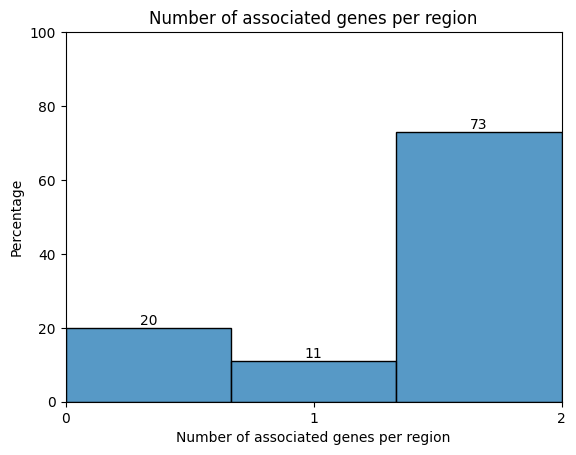

In [141]:
import matplotlib.pyplot as plt


res = GREAT.get_nb_asso_per_region(test,regdom)
# df = pd.DataFrame(res).transpose().reset_index()

nb = {
    "number" : [],
    "number_genes" : [],
    "percentage" : [],
}
# for i in list(set(res.values())) :
#     nb["number"].append(i)
#     nb["number_genes"].append(list(res.values()).count(i))
#     nb["percentage"].append((list(res.values()).count(i)/len(res.keys()))*100)
# nb = pd.DataFrame(nb,columns=["number","number_genes","percentage"],index=nb["number"])
# nb
g = sns.histplot(data = res,bins=len(list(set(res.values()))))#, x = "number" , y = "percentage")#, weights="number_genes" , bins = 3)
g.xaxis.set_major_locator(ticker.MultipleLocator(1))
g.xaxis.set_major_formatter(ticker.ScalarFormatter())
g.set_title("Number of associated genes per region")
g.set_xlabel("Number of associated genes per region")
g.set_ylabel("Percentage")
# g.set_x
g.bar_label(g.containers[0])
g = g.set(xlim=(0,2),ylim=(0,100))
plt.show(g)

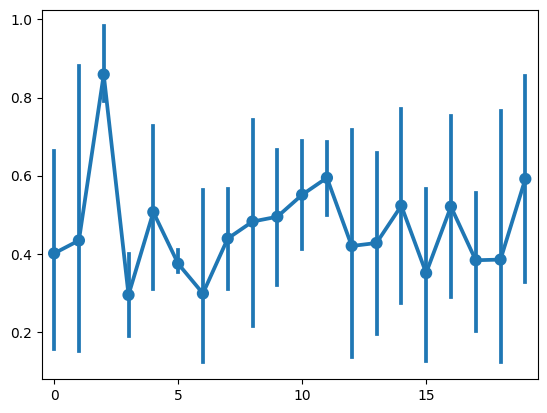

In [120]:
import seaborn.apionly as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np; np.random.seed(1)

x = np.random.randint(0,20,size=(100))
y = np.random.rand(100)

ax = sns.pointplot(x,y )
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

plt.show()

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
df = sns.load_dataset("iris")
df

# sns.histplot(data=df, x="sepal_length", bins=20)
# plt.show()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.10000e+00,3.50000e+00,1.40000e+00,2.00000e-01,setosa
1,4.90000e+00,3.00000e+00,1.40000e+00,2.00000e-01,setosa
2,4.70000e+00,3.20000e+00,1.30000e+00,2.00000e-01,setosa
3,4.60000e+00,3.10000e+00,1.50000e+00,2.00000e-01,setosa
4,5.00000e+00,3.60000e+00,1.40000e+00,2.00000e-01,setosa
...,...,...,...,...,...
145,6.70000e+00,3.00000e+00,5.20000e+00,2.30000e+00,virginica
146,6.30000e+00,2.50000e+00,5.00000e+00,1.90000e+00,virginica
147,6.50000e+00,3.00000e+00,5.20000e+00,2.00000e+00,virginica
148,6.20000e+00,3.40000e+00,5.40000e+00,2.30000e+00,virginica


In [4]:
test = "../../data/tests/test_data/input/01_random.bed"
regdom = "../../data/human/hg38/regulatory_domain.bed"
great_out = "../../data/tests/test_data/output/10_MAX_output_great_webserver.tsv"
great_asso = "../../data/tests/test_data/output/10_MAX_gene_asso.tsv"
size = "../../data/human/hg38/chr_size.bed"

## I Compute the p-values

In [7]:
enrichment_tot = GREAT.enrichment(
    test_file=test,
    regdom_file=regdom,
    chr_size_file=size,
    annotation_file="../../data/human/ontologies.csv",
    binom=True,
    hypergeom=True,
    )

In [8]:
enrichment_tot

,go_term,binom_p_value,binom_fold_enrichment,hypergeom_p_value,hypergeometric_fold_enrichment
GO:0045887,positive regulation of synaptic growth at neur...,5.20389e-13,2.18004e+05,3.08889e-03,3.23741e+02
GO:0044721,"protein import into peroxisome matrix, substra...",4.84198e-10,3.94065e+04,3.08889e-03,3.23741e+02
GO:0036250,peroxisome transport along microtubule,4.84198e-10,3.94065e+04,3.08889e-03,3.23741e+02
GO:0016561,"protein import into peroxisome matrix, translo...",6.31855e-10,3.68645e+04,6.16839e-03,1.61871e+02
GO:0030576,Cajal body organization,1.49190e-09,2.97236e+04,1.83932e-02,5.39569e+01
...,...,...,...,...,...
GO:0006355,"regulation of transcription, DNA-templated",9.93956e-01,2.08617e+01,8.40449e-01,5.54352e-01
GO:0006915,apoptotic process,9.95014e-01,2.01230e+01,5.39651e-01,1.11443e+00
GO:0042803,protein homodimerization activity,9.98551e-01,2.44788e+01,9.54394e-01,3.33067e-01
GO:0005737,cytoplasm,9.98903e-01,6.55886e+01,9.92060e-01,5.70469e-01


Note : computation time 34 min

In [138]:
enrichment_tot[enrichment_tot.index == "GO:0009925"]

,go_term,hypergeom_p_value
GO:0009925,basal plasma membrane,1.11533e-04


real res == 5.0543e-5

## II Compare to GREAT webserver  

### II.1 Import the data

In [139]:
great_webserver = pd.read_csv(great_out,sep="\t",comment="#",
                    names=["ontologie","term_name","ID","binom_p_value","binom_bonferroni","binom_fdr","hyper_p_value","hyper_bonferroni","hyper_fdr"],index_col=False,
                    dtype={"term_name":"object", "ID":"object","binom_p_value":"float64", "binom_bonferroni":"float64", "binom_fdr":"float64", "hyper_p_value":"float64", "hyper_bonferroni":"float64", "hyper_fdr":"float64"})
great_webserver.rename(columns={"ID":"id"},inplace=True)
del great_webserver["ontologie"]
del great_webserver["term_name"]

In [23]:
great_webserver[great_webserver["id"]=="GO:0001664"]

,id,binom_p_value,binom_bonferroni,binom_fdr,hyper_p_value,hyper_bonferroni,hyper_fdr
1992,GO:0001664,1.88231e-04,7.94713e-01,2.64904e-01,3.01450e-04,1.00000e+00,6.36361e-01


### II.2 Compare the results between greatpy and great 

#### II.2.1 Preprocessing

In [140]:
before_pp = enrichment_tot.shape[0]
enrichment_tot = enrichment_tot[enrichment_tot.index.isin(list(great_webserver["id"]))]
after_pp = enrichment_tot.shape[0]

In [141]:
great_webserver = great_webserver[great_webserver["id"].isin(list(enrichment_tot.index))]
great_webserver = great_webserver.sort_values("id")

In [143]:
binom_greatpy = []
hyper_greatpy = []
binom_great = []
hyper_great = []
for i in range(enrichment_tot.shape[0]) : 
    go_id = list(enrichment_tot.index)[i]
    curr_enrichment = enrichment_tot.iloc[i]
    curr_great_webserver = great_webserver.loc[great_webserver["id"]==go_id]
    # binom_greatpy.append(float(curr_enrichment["binom_p_value"]))
    hyper_greatpy.append(float(curr_enrichment["hypergeom_p_value"]))
    # binom_great.append(float(curr_great_webserver["binom_p_value"]))
    hyper_great.append(float(curr_great_webserver["hyper_p_value"]))
# binom = pd.DataFrame({"binom_greatpy":binom_greatpy,"binom_great":binom_great})
hyper = pd.DataFrame({"hyper_greatpy":hyper_greatpy,"hyper_great":hyper_great})

#### II.2.b Graphical

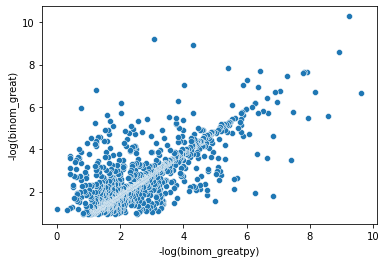

In [14]:
pl=great.pl.scatterplot(binom,colname_x="binom_greatpy",colname_y="binom_great")

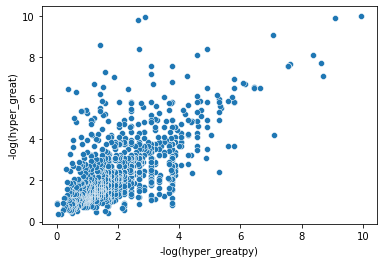

In [144]:
great.pl.scatterplot(hyper,colname_x="hyper_greatpy",colname_y="hyper_great")

In [145]:
pearsonr(binom_great,binom_greatpy)[0],pearsonr(hyper_great,hyper_greatpy)[0]

0.6702324739937066

#### II.2.c Statistics

In [17]:
def stat(binom_great_list_list, hyper_great_listpy_list,binom_great_list,hyper_great_list) : 
    if len(binom_great_list_list) >= 2 and len(hyper_great_listpy_list) >= 2 and len(binom_great_list) >= 2  and len(hyper_great_list) >= 2 : 
        return pd.DataFrame({
            "binom": [cov(m = binom_great_list_list, y = binom_great_list)[0][1],pearsonr(binom_great_list_list,binom_great_list)[0]],
            "hyper":[cov(m = hyper_great_listpy_list, y = hyper_great_list)[0][1],pearsonr(hyper_great_listpy_list,hyper_great_list)[0]]},
            index=["correlation_coefficient","pearson"])
    return False

Issue is : NaN in hyper_fdr

In [18]:
# stat(binom_greatpy, hyper_greatpy,binom_great,hyper_great)

In [146]:
print(f"before preprocessing, greatpy df have {before_pp} rows")
print(f"before preprocessing, great df have {2395} rows")
print(f"after preprocessing, greatpy and great df have {after_pp} rows. ")
print(f"So there are {2395 - after_pp} GO term absent from greatpy while they have been picked up by great thats corresponds to {round(((2395 - after_pp)/2395)*100,2)} % of great output")

before preprocessing, greatpy df have 3011 rows
before preprocessing, great df have 2395 rows
after preprocessing, greatpy and great df have 1482 rows. 
So there are 913 GO term absent from greatpy while they have been picked up by great thats corresponds to 38.12 % of great output


We went from 2766 ontology terms in greatpy output to 248 ontology terms by selecting the GO identifiers present in both greatpy and great 

But when two ontology terms are selected they have the same binomial and hypergeometric probability value 

# How many associations are good or bad 

In [147]:
gene_asso_great = pd.read_csv(great_asso,sep="\t",comment="#",names=["ontologies","gene"],index_col=False, dtype={"ontologies":"object","gene":"object"},usecols=["gene"])
gene_asso_greatpy = great.tl.get_association(
    test = pd.read_csv(test,sep="\t",comment="#",usecols=[0,1,2],names=["Chr", "Chr_Start", "Chr_End"],dtype={"Chr":"object", "Chr_Start":"int64", "Chr_End":"int64"}),
    regdom= pd.read_csv(regdom,sep="\t",comment="#",names=["Chr", "Chr_Start", "Chr_End","Name","tss","Strand"],dtype={"Chr":"object", "Chr_Start":"int64", "Chr_End":"int64","Name":"object","tss":"int64","Strand":"object"}))
in_in = gene_asso_great[gene_asso_great["gene"].isin(gene_asso_greatpy)].shape[0]
in_out = [i for i in list(gene_asso_great["gene"]) if i not in gene_asso_greatpy]
out_in = [i for i in gene_asso_greatpy if i not in list(gene_asso_great["gene"])]

print(f"Number of gene association present in greatpy and great : {in_in}")
print(f"Number of gene association prensent in great and not in greatpy {len(in_out)}")
print(f"Number of gene association prensent in greatpy and not in great {len(out_in)}")

Number of gene association present in greatpy and great : 428
Number of gene association prensent in great and not in greatpy 0
Number of gene association prensent in greatpy and not in great 4
